<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [252]:
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.size'] = 10
plt.style.use("fivethirtyeight")

In [253]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [254]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column


In [255]:
#total nulls
print(X.isnull().any(), X.isnull().sum(),"\n")
print(y.isnull().any(),y.isnull().sum())

CRIM       False
ZN         False
INDUS      False
CHAS       False
NOX        False
RM         False
AGE        False
DIS        False
RAD        False
TAX        False
PTRATIO    False
B          False
LSTAT      False
dtype: bool CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64 

MEDV    False
dtype: bool MEDV    0
dtype: int64


In [256]:
#index
X.index, y.index

(RangeIndex(start=0, stop=506, step=1), RangeIndex(start=0, stop=506, step=1))

In [257]:
#data types
X.dtypes, y.dtypes

(CRIM       float64
 ZN         float64
 INDUS      float64
 CHAS       float64
 NOX        float64
 RM         float64
 AGE        float64
 DIS        float64
 RAD        float64
 TAX        float64
 PTRATIO    float64
 B          float64
 LSTAT      float64
 dtype: object, MEDV    float64
 dtype: object)

In [258]:
#shape
X.shape, y.shape

((506, 13), (506, 1))

In [259]:
#summary statistics
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [260]:
X.columns.values

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype=object)

In [261]:
y.describe()

,MEDV
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


In [262]:
#the number of unique values for each column
X.nunique(), y.nunique()

(CRIM       504
 ZN          26
 INDUS       76
 CHAS         2
 NOX         81
 RM         446
 AGE        356
 DIS        412
 RAD          9
 TAX         66
 PTRATIO     46
 B          357
 LSTAT      455
 dtype: int64, MEDV    229
 dtype: int64)

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [263]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [264]:
feature_cols = ['CRIM', 'ZN', 'DIS','AGE']
predictors = X[feature_cols]
target_variable = y.MEDV

linreg = LinearRegression()
linreg.fit(predictors, target_variable)
print ("Score: %f" %linreg.score(predictors, target_variable))

list(zip(feature_cols, linreg.coef_))


Score: 0.286959


[('CRIM', -0.35780497702160247),
 ('ZN', 0.13281396818000141),
 ('DIS', -1.4961259082328671),
 ('AGE', -0.1058603826449855)]

What do these results tell us? <br/> 
A: We can intepret the **score** value as the variability of the predicted data around or close to its targeted value are only  28.7% (note: the desirable score value is value that is close to 100%).
The **coeficient** value tell us the positive or negative relationship of the feature with the respond value 'MEDV'.

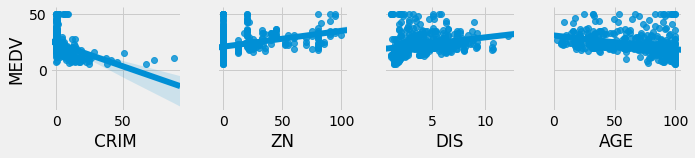

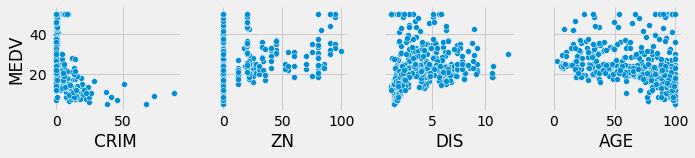

In [265]:
new_df=pd.concat([predictors,target_variable],axis=1) #this put the four features and 'MEDV' in the same dataframe

# multiple scatterplots in Seaborn
sns.pairplot(new_df, x_vars=feature_cols, y_vars='MEDV', kind='reg');
sns.pairplot(new_df, x_vars=feature_cols, y_vars='MEDV', kind='scatter');

What do these results tell us? <br/> 
A: The slope of the fitted linear model using regression plot align with the positive/negative sign of the four feature coefficients i.e. CRIM:"-", ZN:"+", Age:"-", with the exception of DIS:"-" (not sure why).

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [266]:
X70_train, X30_test, y70_train, y30_test=train_test_split(predictors, target_variable, test_size=0.3)
X90_train, X10_test, y90_train, y10_test=train_test_split(predictors, target_variable, test_size=0.1)

lr1=LinearRegression()
lr2=LinearRegression()

lr1.fit(X70_train,y70_train)
lr2.fit(X90_train,y90_train)

print ("Score-70pct training: %f" %lr1.score(X70_train,y70_train))
print ("Score-30pct testing: %f" %lr1.score(X30_test,y30_test))
print ("Score-90pct training: %f" %lr2.score(X90_train,y90_train))
print ("Score-10pct testing: %f" %lr2.score(X10_test,y10_test),"\n")

print ("Coeficient for 70/30 train/test splits:","\n",list(zip(feature_cols, lr1.coef_)))
print ("Intercept for 70/30 train/test splits:",lr1.intercept_,"\n")

print ("Coeficient for 90/10 train/test splits:","\n",list(zip(feature_cols, lr2.coef_)))
print ("Intercept for 90/10 train/test splits:",lr2.intercept_,"\n")



Score-70pct training: 0.358742
Score-30pct testing: 0.134381
Score-90pct training: 0.294878
Score-10pct testing: 0.160707 

Coeficient for 70/30 train/test splits: 
 [('CRIM', -0.39949197667826752), ('ZN', 0.14252929730120073), ('DIS', -1.7063577858136625), ('AGE', -0.12108300684608057)]
Intercept for 70/30 train/test splits: 36.6298328362 

Coeficient for 90/10 train/test splits: 
 [('CRIM', -0.35928788712017662), ('ZN', 0.14229474672005235), ('DIS', -1.5270405675084975), ('AGE', -0.10166246348371491)]
Intercept for 90/10 train/test splits: 35.0266987277 



What does this tell us about the training/testing splits? <br/> 
A: Higher training score value for 70train-30test --> More sample for training will increase the accuracy of the linear model. Although the testing score value is lower that could be the number of test sample size is more. 

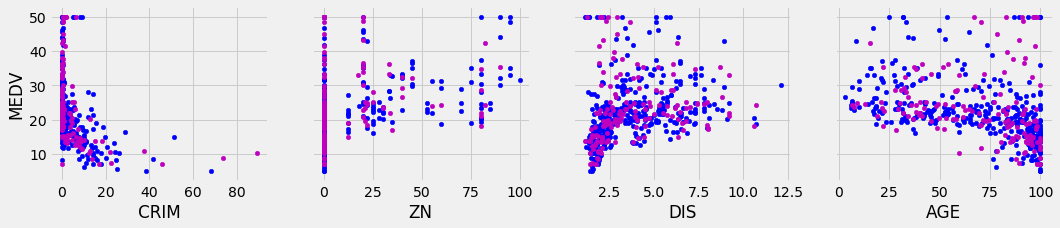

In [267]:
new_df_train=pd.concat([X70_train, y70_train],axis=1)
new_df_test=pd.concat([X30_test, y30_test],axis=1)

# Multiple scatterplots in Pandas
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    new_df_train.plot(kind='scatter', x=feature, y='MEDV', ax=axs[index], figsize=(16, 3),color='b') 
    new_df_test.plot(kind='scatter', x=feature, y='MEDV', ax=axs[index], figsize=(16, 3),color='m') 


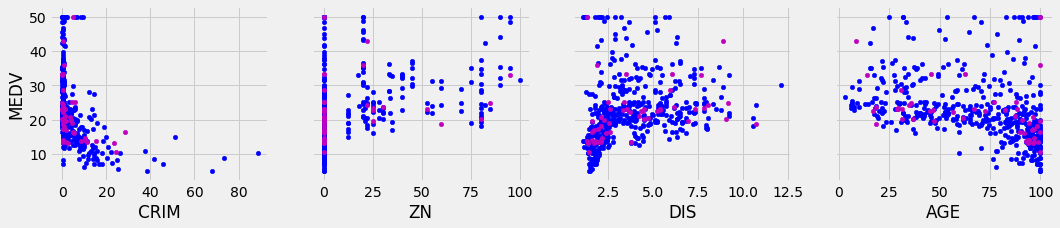

In [268]:
new_df_train=pd.concat([X90_train, y90_train],axis=1)
new_df_test=pd.concat([X10_test, y10_test],axis=1)

# Multiple scatterplots in Pandas
fig, axs = plt.subplots(1, len(feature_cols), sharey=True)
for index, feature in enumerate(feature_cols):
    new_df_train.plot(kind='scatter', x=feature, y='MEDV', ax=axs[index], figsize=(16, 3),color='b') 
    new_df_test.plot(kind='scatter', x=feature, y='MEDV', ax=axs[index], figsize=(16, 3),color='m') 


### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [269]:
#Solution 1

from sklearn.model_selection import KFold

#feature_cols = ['CRIM', 'ZN', 'DIS','AGE']
#predictors = X[feature_cols]
#target_variable = y.MEDV

for i in range (5,11):
    print (i)
    kf=KFold(n_splits=i)
    score=[]
    for train_index, valid_index in kf.split(predictors):
        #print('TRAIN:', train_index, 'TEST:', test_index)
        X_train, X_valid = predictors.iloc[train_index], predictors.iloc[valid_index]
        y_train, y_valid = target_variable.iloc[train_index], target_variable.iloc[valid_index]
        linreg = LinearRegression()
        linreg.fit(X_train, y_train)
        print ("Score: %f" %linreg.score(X_valid, y_valid))
        score.append(linreg.score(X_valid, y_valid))
    print("Average score for k: %i is %f" %(i,sum(score)/len(score)))

5
Score: 0.114242
Score: 0.189777
Score: -0.334449
Score: 0.170197
Score: -0.793703
Average score for k: 5 is -0.130787
6
Score: 0.086418
Score: -0.017479
Score: -0.285307
Score: 0.019541
Score: -0.526701
Score: -0.979154
Average score for k: 6 is -0.283780
7
Score: 0.109491
Score: -0.146777
Score: -0.048588
Score: -0.568054
Score: 0.012031
Score: -0.877308
Score: -0.646521
Average score for k: 7 is -0.309389
8
Score: 0.355192
Score: -0.335632
Score: 0.023688
Score: -0.110645
Score: -0.147767
Score: -0.152621
Score: -2.646573
Score: -0.672818
Average score for k: 8 is -0.460897
9
Score: 0.322847
Score: -0.255186
Score: -0.060329
Score: -0.141736
Score: -0.583000
Score: 0.267815
Score: 0.065172
Score: -1.870012
Score: -0.589156
Average score for k: 9 is -0.315954
10
Score: 0.309964
Score: -0.356683
Score: -4.177198
Score: -0.398248
Score: -0.297323
Score: -0.419070
Score: -0.325313
Score: 0.148640
Score: -1.770090
Score: -0.526762
Average score for k: 10 is -0.781208


In [270]:
#Solution 2

from sklearn.model_selection import cross_val_score
score=cross_val_score(linreg,predictors,target_variable,cv=5)
print ('k=5 %s. Average Score: %f, Variance: %f' %(score, score.mean(),score.var()))

score=cross_val_score(linreg,predictors,target_variable,cv=6)
print ('k=6 %s. Average Score: %f, Variance: %f' %(score, score.mean(),score.var()))

score=cross_val_score(linreg,predictors,target_variable,cv=7)
print ('k=7 %s. Average Score: %f, Variance: %f' %(score, score.mean(),score.var()))

score=cross_val_score(linreg,predictors,target_variable,cv=8)
print ('k=8 %s. Average Score: %f, Variance: %f' %(score, score.mean(),score.var()))

score=cross_val_score(linreg,predictors,target_variable,cv=9)
print ('k=9 %s. Average Score: %f, Variance: %f' %(score, score.mean(),score.var()))

score=cross_val_score(linreg,predictors,target_variable,cv=10)
print ('k=10 %s. Average Score: %f, Variance: %f' %(score, score.mean(),score.var()))

k=5 [ 0.11424153  0.18977711 -0.33444869  0.17019651 -0.79370334]. Average Score: -0.130787, Variance: 0.146866
k=6 [ 0.08641791 -0.01747882 -0.28530726  0.0195408  -0.52670137 -0.97915354]. Average Score: -0.283780, Variance: 0.140421
k=7 [ 0.10949085 -0.14677722 -0.04858757 -0.56805405  0.01203054 -0.87730768
 -0.64652063]. Average Score: -0.309389, Variance: 0.125190
k=8 [ 0.35519201 -0.33563174  0.02368756 -0.11064455 -0.14776678 -0.15262124
 -2.64657291 -0.67281807]. Average Score: -0.460897, Variance: 0.756796
k=9 [ 0.32284657 -0.25518611 -0.06032926 -0.14173641 -0.58300045  0.26781495
  0.0651717  -1.8700124  -0.58915633]. Average Score: -0.315954, Variance: 0.394950
k=10 [ 0.30996426 -0.35668305 -4.17719795 -0.39824786 -0.29732301 -0.41906976
 -0.32531302  0.14864034 -1.77008989 -0.52676238]. Average Score: -0.781208, Variance: 1.553066


In [271]:
#Solution 3
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso

lasso=Lasso()
linreg = LinearRegression()


In [272]:
score=cross_val_score(lasso,predictors,target_variable,cv=5)
print ('k=5 %s. Average Score: %f, Variance: %f' %(score, score.mean(),score.var()))

score=cross_val_score(lasso,predictors,target_variable,cv=6)
print ('k=6 %s. Average Score: %f, Variance: %f' %(score, score.mean(),score.var()))

score=cross_val_score(lasso,predictors,target_variable,cv=7)
print ('k=7 %s. Average Score: %f, Variance: %f' %(score, score.mean(),score.var()))

score=cross_val_score(lasso,predictors,target_variable,cv=8)
print ('k=8 %s. Average Score: %f, Variance: %f' %(score, score.mean(),score.var()))

score=cross_val_score(lasso,predictors,target_variable,cv=9)
print ('k=9 %s. Average Score: %f, Variance: %f' %(score, score.mean(),score.var()))

score=cross_val_score(lasso,predictors,target_variable,cv=10)
print ('k=10 %s. Average Score: %f, Variance: %f' %(score, score.mean(),score.var()))

k=5 [ 0.12540518  0.18232308 -0.44102367  0.12733682 -0.64420431]. Average Score: -0.130033, Variance: 0.118028
k=6 [ 0.08389625  0.00818544 -0.33574579 -0.09493479 -0.24209414 -0.84327004]. Average Score: -0.237327, Variance: 0.093435
k=7 [ 0.0965137  -0.03340142 -0.11378441 -0.66772499 -0.16716768 -0.34914388
 -0.54280373]. Average Score: -0.253930, Variance: 0.066050
k=8 [ 0.24197021 -0.19480915  0.00904388 -0.1363561  -0.28169862 -0.28158968
 -1.88228079 -0.54356945]. Average Score: -0.383661, Variance: 0.366838
k=9 [ 0.2528035  -0.16785108 -0.03066939 -0.23914926 -0.69730465  0.23880695
  0.01223741 -1.78544427 -0.44745501]. Average Score: -0.318225, Variance: 0.352250
k=10 [ 0.25601926 -0.30998302 -3.25567484 -0.4821855  -0.28918966 -0.59057319
 -0.71952413  0.15163993 -1.59163604 -0.37573647]. Average Score: -0.720684, Variance: 0.944730


# KNN Practice

In [273]:
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [274]:
iris.head()

# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['font.size'] = 14

iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [275]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

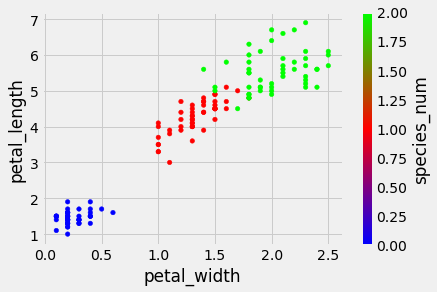

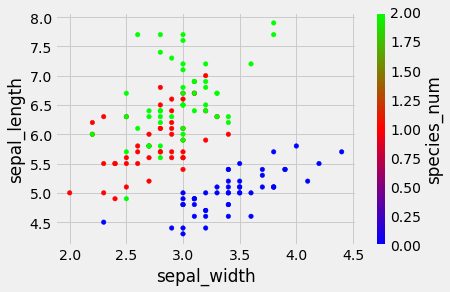

In [276]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})

# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
iris.plot(kind="scatter", x="petal_width", y="petal_length", c="species_num", colormap="brg")


# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
iris.plot(kind="scatter", x="sepal_width", y="sepal_length", c="species_num", colormap="brg")

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [277]:
X= iris[col_names].drop('species',axis=1)

X.head(3)

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


### Create your target vector "y"
This will be the species type.

In [278]:
y=iris.species_num
y.head(3)

0    0
1    0
2    0
Name: species_num, dtype: int64

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [279]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [280]:
#instantiate a model (for k=1)
k=KNeighborsClassifier(n_neighbors=1)

### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [281]:
#train model using training set and k=1
k.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

In [282]:
#Use test set to determin the accuracy
y_pred = k.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred)))

0.921052631579


### Create a Model With Five Neighbors. Did it Improve?

In [283]:
#instantiate a model (for k=5)
#train model using training set and k=5
#Use test set to determin the accuracy
k1=KNeighborsClassifier(n_neighbors=5)
k1.fit(X_train, y_train)
y_pred=k1.predict(X_test)
print((metrics.accuracy_score(y_test,y_pred)))

0.921052631579


### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [284]:
accuracy=[]
k_range=range(1,101)


for i in k_range:
    k2=KNeighborsClassifier(n_neighbors=i)
    k2.fit(X_train, y_train)
    y_pred=k2.predict(X_test)
    training_accuracy=metrics.accuracy_score(y_test, y_pred)
    accuracy.append(training_accuracy)

#create new dataframe to store k_range and accuracy
column_dict={"K":k_range,"Accuracy":accuracy}
df=pd.DataFrame(column_dict).set_index("K").sort_values("Accuracy", ascending= True)
df.index

Int64Index([100,  84,  85,  86,  87,  88,  89,  90,  83,  92,  91,  98,  97,
             99,  95,  94,  96,  93,  73,  74,  75,  77,  76,  80,  81,  82,
             78,  79,  65,  69,  68,  67,  66,   1,   2,   3,   5,  19,  31,
             20,  17,  23,  21,  30,  18,  62,  64,  29,  70,  58,  71,  16,
             15,   4,   6,   7,   8,  52,   9,  11,  47,  13,  14,  45,  72,
             22,  10,  24,  25,  12,  26,  27,  35,  34,  36,  37,  38,  39,
             40,  41,  42,  43,  44,  46,  48,  28,  49,  51,  53,  54,  55,
             56,  57,  59,  60,  61,  63,  32,  33,  50],
           dtype='int64', name='K')

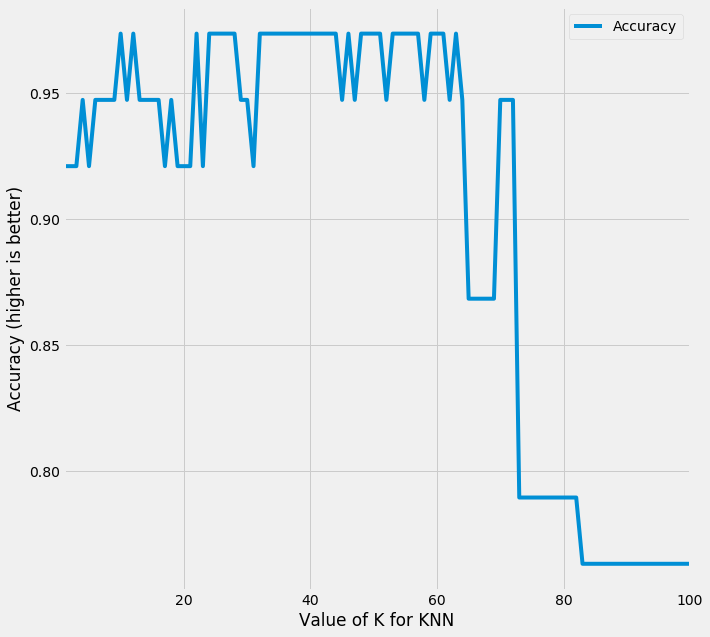

In [285]:
df=pd.DataFrame(column_dict).set_index("K").sort_index(ascending=True)
#Plot the relationship between k_range vs accuracy
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.rcParams['font.size'] = 14
plt.style.use('fivethirtyeight')

df.plot(y="Accuracy")
plt.xlabel('Value of K for KNN');
plt.ylabel('Accuracy (higher is better)');

### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

A: <span style="color:blue">Predict the probablities for each class and return an array of probablities from 0 to 1 for each class. </span>

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [286]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [287]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM-1",
    "case3": "MEDV ~ RAD + TAX-1",
    "case4": "MEDV ~ CRIM + ZN + DIS + AGE-1",
    "case5": "MEDV ~ CRIM + ZN + INDUS + DIS + AGE-1"
}

for key in formulas:
    model = smf.ols(formula=formulas[key], data=df)
    result = model.fit()
    print (result.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     1220.
Date:                Sun, 29 Apr 2018   Prob (F-statistic):          1.59e-321
Time:                        18:32:00   Log-Likelihood:                -1567.7
No. Observations:                 506   AIC:                             3151.
Df Residuals:                     498   BIC:                             3185.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9744      0.224     22.197      0.0

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

In [288]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

#reload data
X1 = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y1 = pd.DataFrame(boston.target,
                 columns=['MEDV'])

#select features to optimise R2 score
feature_cols = [ 'RM', 'LSTAT', 'PTRATIO']
predictors = X1[feature_cols]
target_variable = y1.MEDV

kf=KFold(n_splits=10)

score=[]

for train_index, valid_index in kf.split(predictors):
    #print('TRAIN:', train_index, 'VALID:', valid_index)
    X_train, X_valid = predictors.iloc[train_index], predictors.iloc[valid_index]
    y_train, y_valid = target_variable.iloc[train_index], target_variable.iloc[valid_index]
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    print ("Score: %f" %linreg.score(X_valid, y_valid))
    score.append(linreg.score(X_valid, y_valid))
print("Average score for k: %i is %f" %(10,sum(score)/len(score)))
    

Score: 0.763830
Score: 0.644574
Score: -0.591617
Score: 0.558549
Score: 0.604443
Score: 0.658509
Score: 0.057566
Score: 0.056619
Score: -1.129852
Score: 0.476216
Average score for k: 10 is 0.209884


### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

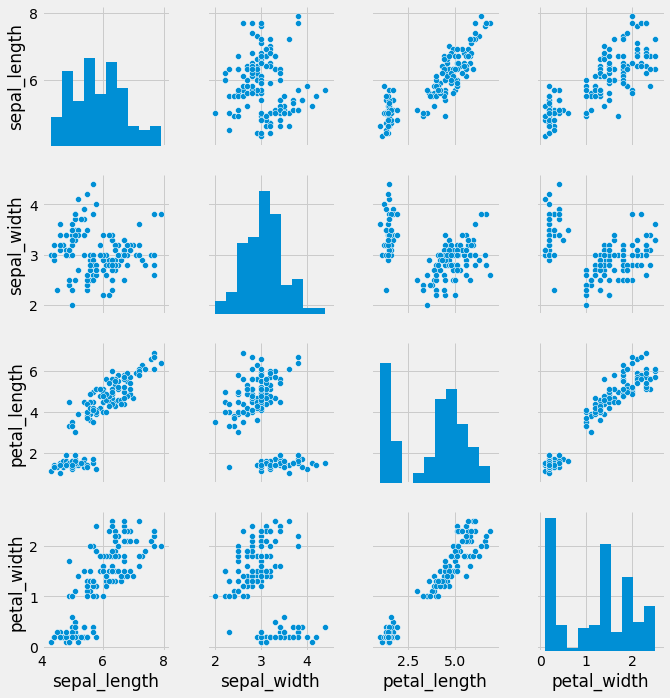

In [289]:
# Check out variable relations
import seaborn as sns
from scipy.stats.stats import pearsonr

sns.pairplot(X);

In [290]:
# Other predictor (e.g. Sepal length)
feature_cols= ['sepal_width','petal_length','petal_width']
X2=X[feature_cols]
y2=X.sepal_length

X2_train, X2_test, y2_train, y2_test=train_test_split(X2, y2, test_size=0.25)

linreg=LinearRegression()
linreg.fit(X2_train,y2_train)
print ("Coeficient (using linear regression):","\n",list(zip(feature_cols, linreg.coef_)))


Coeficient (using linear regression): 
 [('sepal_width', 0.63286720767690652), ('petal_length', 0.74444872355469638), ('petal_width', -0.65229369308142948)]


In [291]:
# Check out Pearson score

print("Pearson score 'sepal_width':", pearsonr(X2['sepal_width'],y2))
print("Pearson score 'petal_length':", pearsonr(X2['petal_length'],y2))
print("Pearson score 'petal_width':", pearsonr(X2['petal_width'],y2))


Pearson score 'sepal_width': (-0.10936924995064935, 0.18276521527136649)
Pearson score 'petal_length': (0.87175415730487116, 1.0384540627941809e-47)
Pearson score 'petal_width': (0.81795363336916327, 2.3148491512729807e-37)


## Demo: Patsy

In [292]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [293]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [294]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: -0.09993051625627825
